## 6. Create and Art with Neural style transfer on a given image using deep learning.

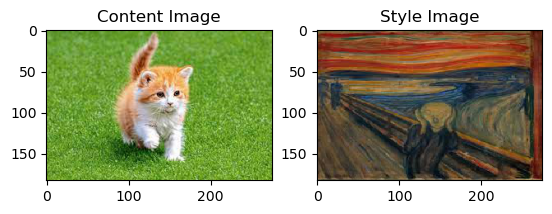

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import vgg19
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import Model
import matplotlib.pyplot as plt

# Define paths to content and style images
content_path = "C:\\Users\\admin\\Documents\\content img.jpeg"
style_path = "C:\\Users\\admin\\Documents\\style img.jpeg"

# Define image dimensions
width, height = load_img(content_path).size
img_size = (height, width)

# Load and preprocess images
def load_and_preprocess_image(path):
    img = load_img(path, target_size=img_size)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

# De-process and display the generated image
def deprocess_img(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

# Load and preprocess content and style images
content_image = load_and_preprocess_image(content_path)
style_image = load_and_preprocess_image(style_path)

# Display content and style images
plt.subplot(1, 2, 1)
plt.imshow(deprocess_img(content_image))
plt.title('Content Image')

plt.subplot(1, 2, 2)
plt.imshow(deprocess_img(style_image))
plt.title('Style Image')
plt.show()

# Define a VGG19 model for feature extraction
vgg = vgg19.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

# Get the outputs from intermediate layers
content_layers = ['block5_conv2']
style_layers = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1',
]

content_outputs = [vgg.get_layer(name).output for name in content_layers]
style_outputs = [vgg.get_layer(name).output for name in style_layers]
model_outputs = content_outputs + style_outputs

# Build the model
model = Model(inputs=vgg.input, outputs=model_outputs)

# Calculate content and style representations
def get_feature_representations(model, content_path, style_path):
    content_image = load_and_preprocess_image(content_path)
    style_image = load_and_preprocess_image(style_path)

    outputs_content = model(content_image)
    outputs_style = model(style_image)

    content_features = [layer[0] for layer in outputs_content[:len(content_layers)]]
    style_features = [tf.expand_dims(layer[0], axis=0) for layer in outputs_style[len(content_layers):]]

    return content_features, style_features

content_features, style_features = get_feature_representations(model, content_path, style_path)

# Define and build the Gram matrix
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    return result / num_locations

# Define loss functions
def style_loss(style, generated):
    style_gram = gram_matrix(style)
    generated_gram = gram_matrix(generated)
    return tf.reduce_mean(tf.square(style_gram - generated_gram))

def content_loss(content, generated):
    return tf.reduce_mean(tf.square(content - generated))

def total_variation_loss(image):
    x_var = tf.square(image[:, :-1, :-1, :] - image[:, 1:, :-1, :])
    y_var = tf.square(image[:, :-1, :-1, :] - image[:, :-1, 1:, :])
    return tf.reduce_mean(x_var + y_var)

# Loss weights
content_weight = 1e3
style_weight = 1e-2
total_variation_weight = 30

# Define optimizer
optimizer = tf.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=1e-1)

# Initialize target image
target_image = tf.Variable(content_image, dtype=tf.float32)

# Training step
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = model(image)
        content_loss_val = 0
        style_loss_val = 0

        content_features_gen = outputs[:len(content_layers)]
        style_features_gen = outputs[len(content_layers):]

        for c, c_gen in zip(content_features, content_features_gen):
            content_loss_val += content_loss(c, c_gen)

        for s, s_gen in zip(style_features, style_features_gen):
            style_loss_val += style_loss(s, s_gen)

        content_loss_val *= content_weight / len(content_layers)
        style_loss_val *= style_weight / len(style_layers)
        total_var_loss = total_variation_loss(image) * total_variation_weight

        total_loss = content_loss_val + style_loss_val + total_var_loss

    grad = tape.gradient(total_loss, image)
    optimizer.apply_gradients([(grad, image)])
    image.assign(tf.clip_by_value(image, 0.0, 255.0))

# Run optimization
num_iterations = 1000
for i in range(num_iterations):
    train_step(target_image)

# Display result
plt.imshow(deprocess_img(target_image.numpy()))
plt.title('Generated Image')
plt.axis('off')
plt.show()
